# Part 5: Manually Updating the State

In [1]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm_with_tools = llm.bind_tools(tools)


memory = SqliteSaver.from_conn_string(":memory:")


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

In [2]:
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt __after__ actions, if desired.
    # interrupt_after=["tools"]
)

In [3]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================

[{'text': "Certainly! I'd be happy to research LangGraph for you. To get the most up-to-date and comprehensive information, I'll use the Tavily search engine to look this up. Let me do that for you now.", 'type': 'text'}, {'id': 'toolu_019ymL3sgtYJDP43wSk842qH', 'input': {'query': 'LangGraph Python library for language models'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_019ymL3sgtYJDP43wSk842qH)
 Call ID: toolu_019ymL3sgtYJDP43wSk842qH
  Args:
    query: LangGraph Python library for language models


In [4]:
snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
existing_message.pretty_print()

================================== Ai Message ==================================

[{'text': "Certainly! I'd be happy to research LangGraph for you. To get the most up-to-date and comprehensive information, I'll use the Tavily search engine to look this up. Let me do that for you now.", 'type': 'text'}, {'id': 'toolu_019ymL3sgtYJDP43wSk842qH', 'input': {'query': 'LangGraph Python library for language models'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_019ymL3sgtYJDP43wSk842qH)
 Call ID: toolu_019ymL3sgtYJDP43wSk842qH
  Args:
    query: LangGraph Python library for language models


In [5]:
from langchain_core.messages import AIMessage, ToolMessage

answer = (
    "LangGraph is a library for building stateful, multi-actor applications with LLMs."
)
new_messages = [
    # The LLM API expects some ToolMessage to match its tool call. We'll satisfy that here.
    ToolMessage(content=answer, tool_call_id=existing_message.tool_calls[0]["id"]),
    # And then directly "put words in the LLM's mouth" by populating its response.
    AIMessage(content=answer),
]

new_messages[-1].pretty_print()
graph.update_state(
    # Which state to update
    config,
    # The updated values to provide. The messages in our `State` are "append-only", meaning this will be appended
    # to the existing state. We will review how to update existing messages in the next section!
    {"messages": new_messages},
)

print("\n\nLast 2 messages;")
print(graph.get_state(config).values["messages"][-2:])

================================== Ai Message ==================================

LangGraph is a library for building stateful, multi-actor applications with LLMs.


Last 2 messages;
[ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='d1b06664-2855-4463-b4fd-d1c8c57a820d', tool_call_id='toolu_019ymL3sgtYJDP43wSk842qH'), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='0b30231f-8e28-4510-a6af-f36a01e0a66f')]


In [6]:
graph.update_state(
    config,
    {"messages": [AIMessage(content="I'm an AI expert!")]},
    # Which node for this function to act as. It will automatically continue
    # processing as if this node just ran.
    as_node="chatbot",
)

{'configurable': {'thread_id': '1',
  'thread_ts': '1ef3859c-5b5c-6794-8003-158bf777a432'}}

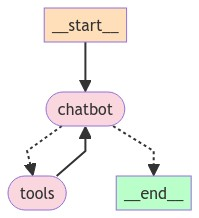

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [8]:
snapshot = graph.get_state(config)
print(snapshot.values["messages"][-3:])
print(snapshot.next)

[ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='d1b06664-2855-4463-b4fd-d1c8c57a820d', tool_call_id='toolu_019ymL3sgtYJDP43wSk842qH'), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='0b30231f-8e28-4510-a6af-f36a01e0a66f'), AIMessage(content="I'm an AI expert!", id='5d6eb3df-3024-4b8a-87a0-7356d40190ec')]
()


In [9]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "2"}}  # we'll use thread_id = 2 here
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================

[{'text': "Certainly! I'd be happy to research LangGraph for you. To get the most up-to-date and comprehensive information, I'll use the Tavily search engine to look this up. Let me do that for you now.", 'type': 'text'}, {'id': 'toolu_01VxeA8VmcVPVXyUDTqJa8mo', 'input': {'query': 'LangGraph framework for language models'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_01VxeA8VmcVPVXyUDTqJa8mo)
 Call ID: toolu_01VxeA8VmcVPVXyUDTqJa8mo
  Args:
    query: LangGraph framework for language models


In [10]:
from langchain_core.messages import AIMessage

snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
print("Original")
print("Message ID", existing_message.id)
print(existing_message.tool_calls[0])
new_tool_call = existing_message.tool_calls[0].copy()
new_tool_call["args"]["query"] = "LangGraph human-in-the-loop workflow"
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[new_tool_call],
    # Important! The ID is how LangGraph knows to REPLACE the message in the state rather than APPEND this messages
    id=existing_message.id,
)

print("Updated")
print(new_message.tool_calls[0])
print("Message ID", new_message.id)
graph.update_state(config, {"messages": [new_message]})

print("\n\nTool calls")
graph.get_state(config).values["messages"][-1].tool_calls

Original
Message ID run-102c1f44-fed7-402e-91e2-5a7f44224a0e-0
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph framework for language models'}, 'id': 'toolu_01VxeA8VmcVPVXyUDTqJa8mo'}
Updated
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph human-in-the-loop workflow'}, 'id': 'toolu_01VxeA8VmcVPVXyUDTqJa8mo'}
Message ID run-102c1f44-fed7-402e-91e2-5a7f44224a0e-0


Tool calls


[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph human-in-the-loop workflow'},
  'id': 'toolu_01VxeA8VmcVPVXyUDTqJa8mo'}]

In [11]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://langchain-ai.github.io/langgraphjs/how-tos/human-in-the-loop/", "content": "Human-in-the-loop. When creating LangGraph agents, it is often nice to add a human in the loop component. This can be helpful when giving them access to tools. Often in these situations you may want to manually approve an action before taking. This can be in several ways, but the primary supported way is to add an \"interrupt\" before a node is ..."}, {"url": "https://github.com/langchain-ai/langgraph/blob/main/examples/human-in-the-loop.ipynb", "content": "human-in-the-loop.ipynb. Cannot retrieve latest commit at this time. History. 980 lines (980 loc) \u00b7 45.7 KB. Build resilient language agents as graphs. Contribute to langchain-ai/langgraph development by creating an account on GitHub."}]
================================== Ai Message ==================================

Than

In [12]:
events = graph.stream(
    {
        "messages": (
            "user",
            "Remember what I'm learning about?",
        )
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember what I'm learning about?
================================== Ai Message ==================================

Of course! You mentioned that you're learning about LangGraph. Is there anything specific about LangGraph that you'd like to know more about or any particular aspects of it that you're finding challenging or interesting in your learning process?
